In [2]:
import cv2
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

In [4]:
benign_file=[]
malignant_file=[]
for root,dirs,files in os.walk("./data",topdown=False):
    if 'label' not in root:
        for file in files:
            if file[-3:]=='tif':
                tmp=file.split('_')
                label_file=str(int(tmp[-1][0:4])-3*116).zfill(3)+'.tif'
                if 'benign' in root:
                    labbel_file_abs=os.path.join(root.replace('benign','benign_label'),label_file)
                elif 'malignant' in root:
                    labbel_file_abs=os.path.join(root.replace('malignant','malignant_label'),label_file)
                if os.path.isfile(labbel_file_abs):
                    if 'benign' in root :
                        benign_file.append((os.path.join(root,file),labbel_file_abs))
                    elif 'malignant' in root:
                        malignant_file.append((os.path.join(root,file),labbel_file_abs))
                        


In [5]:
def computCenter(img_bin):
    contours,_=cv2.findContours(img_bin,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    cnt=contours[0]
    box=cv2.boundingRect(cnt)
    return box

In [6]:
img_size=75
benign_img=[]
for ori,label in benign_file:
    ori_img=cv2.imread(ori,0)
    label_img=cv2.imread(label,0)
    x,y,w,h=computCenter(label_img)
    ori_img=ori_img[y:y+img_size,x:x+img_size]
    label_img=label_img[y:y+h,x:x+w]
    ori_img=np.reshape(ori_img,(1,ori_img.shape[0],ori_img.shape[1]))

    benign_img.append(ori_img)

benign_img=np.asarray(benign_img)
print(benign_img.shape)

(0,)


In [7]:
img_size=75
malignant_img=[]
for ori,label in malignant_file:
    ori_img=cv2.imread(ori,0)
    label_img=cv2.imread(label,0)
    x,y,w,h=computCenter(label_img)
    ori_img=ori_img[y:y+img_size,x:x+img_size]
    label_img=label_img[y:y+h,x:x+w]
    ori_img=np.reshape(ori_img,(1,ori_img.shape[0],ori_img.shape[1]))

    malignant_img.append(ori_img)

malignant_img=np.asarray(malignant_img)
print(malignant_img.shape)

(0,)


In [8]:
from torch.utils.data import Dataset
class CustomTensorDataset(Dataset):
    def __init__(self,tensors,transforms=None):
        assert all(tensors[0].size(0)==tensor.size(0) for tensor in tensors)
        self.tensors=tensors
        self.transform=transforms

    def __getitem__(self,index):
        x=self.tensors[0][index]

        if self.transform:
            x=self.transform(x)

        y=self.tensors[1][index]

        return x,y

    def __len__(self):
        return self.tensors[0].size(0)

In [9]:
from sklearn.model_selection import train_test_split
y=[0]*len(benign_img)+[1]*len(malignant_img)
x=np.concatenate((benign_img,malignant_img),axis=0)
print(x.shape)
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.2,shuffle=True,random_state=7)

(0,)


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [11]:
from torch.utils.data import DataLoader,TensorDataset,Dataset
train_x=torch.tensor(train_x)
test_x=torch.tensor(test_x)/255
train_y=torch.tensor(train_y)
test_y=torch.tensor(test_y)
train_ids=CustomTensorDataset(tensors=(train_x,train_y),transforms=transform)
train_loader=DataLoader(dataset=train_ids,batch_size=32,shuffle=True)
train_dl=TensorDataset(test_x,test_y)
test_loader=DataLoader(dataset=train_dl,batch_size=test_y.shape[0])

In [12]:
for i ,data in enumerate(train_loader):
    print(i,data[0].shape)
    break

0 torch.Size([32, 1, 75, 75])


In [54]:
class Net1(nn.Module):
    def __init__(self)->None:
        super(Net1,self).__init__()
        self.conv1=nn.Conv2d(1,8,kernel_size=5)
        self.conv2=nn.Conv2d(8,16,kernel_size=3)
        self.conv3=nn.Conv2d(16,32,kernel_size=3)
        self.conv2_drop=nn.Dropout2d()
        self.fc1=nn.Linear(7*7*32,512)
        self.fc2=nn.Linear(512,64)
        self.fc3=nn.Linear(64,2)
        self.rule=nn.ReLU()
        self.maxp=nn.MaxPool2d(2)
        self.sig=nn.Sigmoid()
        self.fla=nn.Flatten(1)

    def forward(self,x):
        out=self.conv1(x)
        out=self.rule(out)
        out=self.maxp(out)
        out=self.conv2(out)
        out=self.rule(out)
        out=self.maxp(out)
        out=self.conv3(out)
        out=self.rule(out)
        out=self.maxp(out)

        out=self.fla(out)
        out=self.fc1(out)
        out=self.rule(out)
        out=self.fc2(out)
        out=self.rule(out)
        out=self.fc3(out)
        out=self.rule(out)
        out=self.sig(out)

        return out

In [55]:
learning_rate=0.001
momentum=0.5
network=Net1()
optimizer=optim.Adam(network.parameters(),lr=learning_rate)

In [56]:
log_interval=10
def train(network,epoch):
    network.train()

    for batch_idx,(data,target) in enumerate(train_loader):
        optimizer.zero_grad()
        output=network(data)
        loss=F.cross_entropy(output,target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval==0:
            train_losses.append(loss.item())
            train_counter.append(batch_idx*64+(epoch-1)*len(train_loader.dataset))


In [57]:
def test(network):
    network.eval()
    test_loss=0
    correct=0
    with torch.no_grad():
        for data,target in test_loader:
            output=network(data)

            test_loss +=F.cross_entropy(output,target,size_average=False).item()

            pred=output.data.max(1,keepdim=True)[1]
            correct +=pred.eq(target.data.view_as(pred)).sum()
        test_loss/=len(test_loader.dataset)
        test_losses.append(test_loss)
        print('Test set:Avg. loss:{:.4f},Accuracy:{}/{} ({:.0f}%)'.format(test_loss,correct,len(test_loader.dataset),100.*correct/len(test_loader.dataset)))

print(network)


Net1(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (rule): ReLU()
  (maxp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (sig): Sigmoid()
  (fla): Flatten(start_dim=1, end_dim=-1)
)


In [58]:
n_epochs=200
train_losses=[]
train_counter=[]
test_losses=[]
test_counter=[i*len(train_loader.dataset) for  i in range(n_epochs +1)]
test(network)
for epoch in range(1,n_epochs+1):
    train(network,epoch)
    test(network)


d:\miniconda\envs\gpu\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set:Avg. loss:0.6945,Accuracy:147/326 (45%)
Test set:Avg. loss:0.6891,Accuracy:179/326 (55%)
Test set:Avg. loss:0.6874,Accuracy:181/326 (56%)
Test set:Avg. loss:0.6880,Accuracy:182/326 (56%)
Test set:Avg. loss:0.6779,Accuracy:198/326 (61%)
Test set:Avg. loss:0.6743,Accuracy:197/326 (60%)
Test set:Avg. loss:0.6747,Accuracy:195/326 (60%)
Test set:Avg. loss:0.6811,Accuracy:184/326 (56%)
Test set:Avg. loss:0.6784,Accuracy:190/326 (58%)
Test set:Avg. loss:0.6778,Accuracy:186/326 (57%)
Test set:Avg. loss:0.6768,Accuracy:185/326 (57%)
Test set:Avg. loss:0.6731,Accuracy:197/326 (60%)
Test set:Avg. loss:0.6813,Accuracy:189/326 (58%)
Test set:Avg. loss:0.6736,Accuracy:186/326 (57%)
Test set:Avg. loss:0.6673,Accuracy:199/326 (61%)
Test set:Avg. loss:0.6611,Accuracy:210/326 (64%)
Test set:Avg. loss:0.6667,Accuracy:199/326 (61%)
Test set:Avg. loss:0.6662,Accuracy:192/326 (59%)
Test set:Avg. loss:0.6682,Accuracy:196/326 (60%)
Test set:Avg. loss:0.6597,Accuracy:201/326 (62%)
Test set:Avg. loss:0

Text(0.5, 0, 'number of training examples seen')

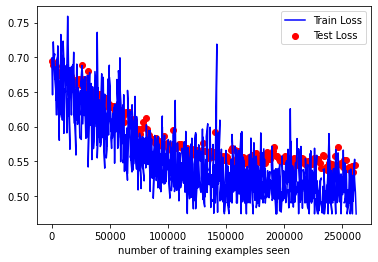

In [59]:
import matplotlib.pyplot as plt
fig=plt.figure()
plt.plot(train_counter,train_losses,color='blue')
plt.scatter(test_counter,test_losses,color='red')
plt.legend(['Train Loss','Test Loss'],loc='upper right')
plt.xlabel('number of training examples seen')